In [8]:
# Author: Chase J. Shyu
# Email: iamhemry@gmail.com
# Created date: June 3rd, 2021
# Updated date: June 4th, 2021
import datetime, math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

In [9]:
# 2021/04台灣人口 23,514,196
# Wikipedia: https://zh.wikipedia.org/zh-tw/臺灣人口
population_202104 = 23514196

# for read data
csv_filename = 'VaccineCOVID19Taiwan - public.csv'
Date = '日期'
Event = '事件'
InjectedAmount = '校正累計施打'
ConfirmedLocalAmount = '累計本土確診'
ConfirmedLocalDaily = '單日本土確診'
DeathAmount = '累計死亡'
DeathDaily = '單日死亡'

# read data
df = pd.read_csv(csv_filename)
df = df[~df[Date].isnull()]
df.loc[:,Date] = df[Date].astype('datetime64[ns]')
df['mavg'] = df[InjectedAmount].interpolate()
df.set_index(Date,inplace=True)

# for plot
title = '臺灣COVID-19疫苗接種統計報表'
label_right = '單日本土確診/死亡(人)'
label_left = '累計疫苗接種(%)'
label_bottom = '日期(西元)'
label_confirmed = '單日本土確診(人)'
label_death = '單日死亡(人)'
text_population = '臺灣人口基數(2021-04)：'+ f'{population_202104:,}' +'人'
text_last_updated = '最後更新日期：%s'%df.index[-1].strftime('%Y-%m-%d')
confirmedAmount = int(df[ConfirmedLocalAmount].max())
deathDeath = int(df[DeathAmount].max())
text_confirmed_amount = '累計本土確診/死亡：' + f'{confirmedAmount:,}/' + f'{deathDeath:,}' +'人'
text_sign = '資料整理：Chase J. Shyu'

vaccine_color = 'blue'
death_color = 'red'
confirmd_color = 'pink'
title_size = 36
label_size = 20
tick_size = 16
legend_title_size = 12
event_size = 10
figsize = (16, 12)

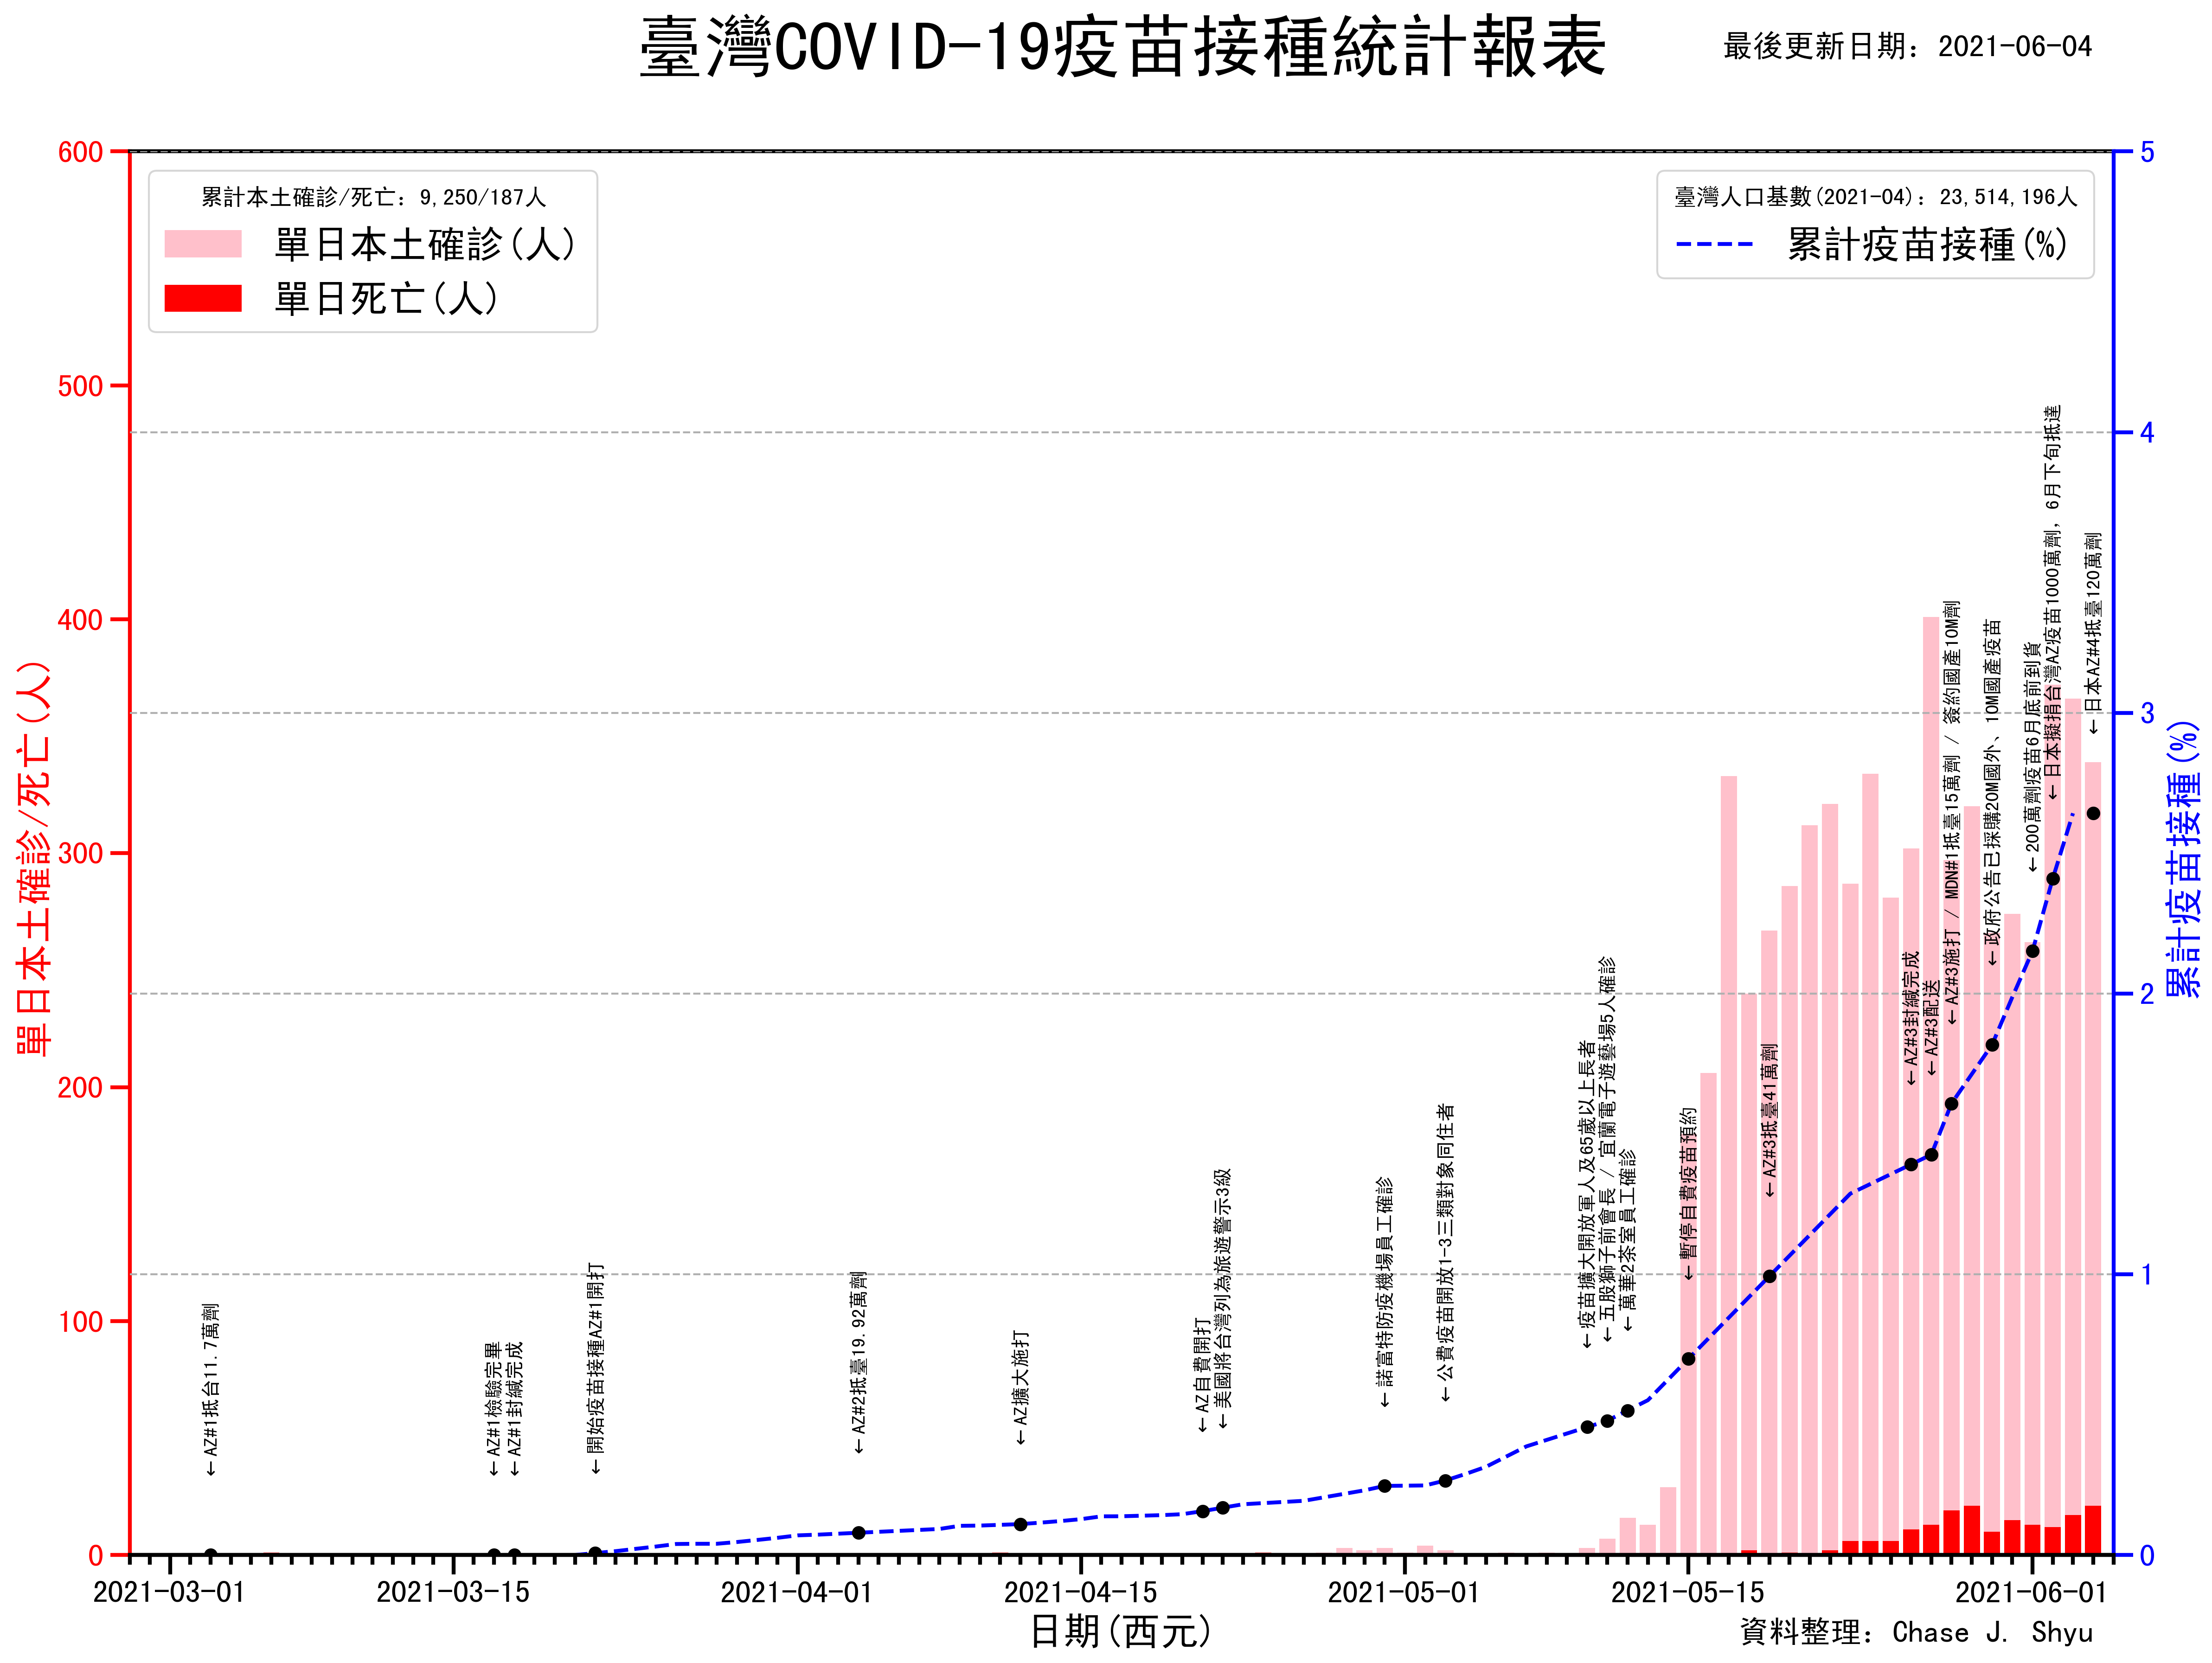

In [10]:
# plot
# https://medium.com/@jackielo_69076/mac-matplotlib-顯示中文-e10c8394300c
#from matplotlib.font_manager import _rebuild
#_rebuild()
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

mpl.rcParams['xtick.labelsize'] = tick_size
mpl.rcParams['ytick.labelsize'] = tick_size
mpl.rcParams['legend.title_fontsize'] = legend_title_size

fig, ax_covid = plt.subplots(1,1,figsize=figsize,dpi=300)
ax_vaccine = ax_covid.twinx()

# plot confirmed case and death
ax_covid.bar(df.index, df[ConfirmedLocalDaily],color=confirmd_color,label=label_confirmed)
ax_covid.bar(df.index, df[DeathDaily],color=death_color,label=label_death)
ax_covid.legend(loc=2,fontsize=label_size,title=text_confirmed_amount)

ax_covid.set_ylim(0,600)
ax_covid.set_ylabel(label_right, fontsize=label_size)
ax_covid.set_xlabel(label_bottom, fontsize=label_size)
ax_covid.spines['left'].set_color(death_color)
ax_covid.spines['right'].set_visible(False)
ax_covid.yaxis.label.set_color(death_color)
ax_covid.tick_params(axis='y',colors=death_color)
for axis in ['top','bottom','left','right']:
    ax_covid.spines[axis].set_linewidth(2)
ax_covid.tick_params(which='major', length=10, width=2)
ax_covid.tick_params(which='minor', length=5, width=2)

# plot vaccine injected amount
ind = ~df[InjectedAmount].isnull()
ax_vaccine.plot(df.index[ind], df[InjectedAmount][ind]/population_202104*100,
                '--',color=vaccine_color, linewidth = 2,label=label_left)

# text event information
y_shift = ax_vaccine.get_ylim()[1]*0.1
ind = ~df[Event].isnull()
for i in df[ind].index:
    ycoord = df.loc[i,'mavg'] / population_202104*100 + y_shift
    ax_vaccine.text(i,ycoord,'$\leftarrow$'+ df.loc[i,Event],
                    rotation=90,fontsize=event_size,horizontalalignment='center')
ax_vaccine.plot(df.index[ind], df["mavg"][ind]/population_202104*100 ,'o',color='black')
ax_vaccine.legend(loc=1,fontsize=label_size,title=text_population)

ax_vaccine.grid(linestyle = '--', linewidth = 1)
ax_vaccine.set_ylim(0,math.ceil(ax_vaccine.get_ylim()[1] * 1.7))
ax_vaccine.set_xlim(df.index[10]+datetime.timedelta(days=18),df.index[-1]+datetime.timedelta(days=1))
ax_vaccine.set_ylabel(label_left, fontsize=label_size)
ax_vaccine.set_title(title,fontsize=title_size,y=1.05)
ax_vaccine.text(df.index[-1],ax_vaccine.get_ylim()[1]*1.065,
                text_last_updated,
               fontsize=tick_size,ha='right',va='bottom')
ax_vaccine.text(df.index[-1],-ax_vaccine.get_ylim()[1]*0.065,text_sign,fontsize=tick_size,ha='right',va='bottom')
ax_vaccine.spines['top'].set_visible(False)
ax_vaccine.spines['left'].set_visible(False)
ax_vaccine.spines['right'].set_color(vaccine_color)
for axis in ['top','bottom','left','right']:
    ax_vaccine.spines[axis].set_linewidth(2)
ax_vaccine.yaxis.label.set_color(vaccine_color)
ax_vaccine.tick_params(axis='y',colors=vaccine_color)
ax_vaccine.xaxis.set_minor_locator(mdates.DayLocator())
ax_vaccine.tick_params(which='major', length=10, width=2)

# save figure
plt.tight_layout()
plt.savefig('VaccineCOVID19Taiwan.jpg',dpi=300)
#plt.close()